In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from nltk.tree import Tree
import svgling

import networkx as nx
from scipy import sparse

from IPython import embed

In [2]:
import pickle

save_dir = "D:\\MIT\\Courses\\2023-Spring\\6.8630-NLP\\Final Project\\LLM CGW\\All Parse Trees"

### Convert Tree to Graph

In [3]:
from nltk.tree.probabilistic import ProbabilisticTree

def get_node_structure(node, max_id):
    label = max_id+1
    max_id_temp = max_id+1
    
    children = []
    for i in range(len(node)):
        if type(node[i]) in [ProbabilisticTree, Tree]:
            child, max_id_temp = get_node_structure(node[i], max_id_temp)
            children.append(child)
        else:
            max_id_temp += 1
            children.append([max_id_temp])
            
    
    return [label, children], max_id_temp

In [4]:
def convert_graph(tree):
    node_structure, num_nodes = get_node_structure(tree, 0)
    
    queue = [node_structure]
    
    G = nx.DiGraph()
    
    while len(queue)>0:
        node = queue.pop(0)
        
        if len(node)>1:
            parent_id = node[0]
            children = node[1]
        
            for i in range(len(children)):
                child = children[i]
                child_id = child[0]
            
                G.add_edge(parent_id, child_id)
            
                queue.append(child)
        else: # leaf node, edge pointing to it is already added, so continue without any additional operations
            continue
    
    return G

### Graph-related Computation for Trees

In [5]:
def network_measures(G, model):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    if model == 'PCFG':
        width = G.degree[2]
        depth = len(nx.dag_longest_path(G))-1
    elif model == 'Google':
        width = G.degree[1]-1
        depth = len(nx.dag_longest_path(G))
    else:
        width = G.degree[1]
        depth = len(nx.dag_longest_path(G))
    
    betweenness_centrality = dict(nx.betweenness_centrality(G.to_undirected()))
    betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
    max_betweenness = (list(betweenness_centrality.keys())[0], list(betweenness_centrality.values())[0])
    mean_betweenness = np.mean((np.array(list(betweenness_centrality.values()))))
    
    degree_centrality = dict(nx.degree_centrality(G.to_undirected()))
    degree_centrality = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
    max_degree = (list(degree_centrality.keys())[0], list(degree_centrality.values())[0])
    mean_degree = np.mean((np.array(list(degree_centrality.values()))))
    
    measures = {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'width': width,
        'depth': depth,
        'max_betweenness': max_betweenness,
        'mean_betweenness': mean_betweenness,
        'max_degree_centrality': max_degree,
        'mean_degree_centrality': mean_degree
    }
    return measures

### Read Sentences

In [6]:
def read_file_lines(text_file):
    """
        reads the text_file
        returns a list of uncommented lines
    """
    lines = []
    with open(text_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                continue  # comment
            lines.append(line)
    return lines

## Base

In [7]:
MODELS = ['PCFG', 'ChatGPT', 'Google']

all_base_trees = {'PCFG':[], 'ChatGPT':[], 'Google':[]}

for i in range(3):
    model = MODELS[i]
    with open(save_dir+'\\Trees\\'+model+'_Base_Trees.pkl', 'rb') as f:
        trees = pickle.load(f)
        
    for tree in trees:
        all_base_trees[model].append(tree)

In [8]:
base_sent = read_file_lines(save_dir + '\\Sentences\\base-set.sen')

In [9]:
all_base_metrics = {'Sent':[], 'PCFG':[], 'ChatGPT':[], 'Google':[]}

for sent in base_sent:
    all_base_metrics['Sent'].append(sent)

for idx in range(len(base_sent)):
    for model in MODELS:
        tree = all_base_trees[model][idx]
        graph = convert_graph(tree)
        all_base_metrics[model].append(network_measures(graph, model))

In [10]:
for idx in range(len(base_sent)):
    print(idx)
    print(all_base_metrics['Sent'][idx])
    for metric in list(all_base_metrics['PCFG'][0].keys()):
        print("  {}: ".format(metric))
        print("    PCFG: {}  ChatGPT: {}  Google: {}".format(all_base_metrics['PCFG'][idx][metric], 
                                                          all_base_metrics['ChatGPT'][idx][metric], 
                                                          all_base_metrics['Google'][idx][metric]))

0
Arthur rode to Camelot .
  num_nodes: 
    PCFG: 22  ChatGPT: 15  Google: 17
  num_edges: 
    PCFG: 21  ChatGPT: 14  Google: 16
  width: 
    PCFG: 3  ChatGPT: 3  Google: 3
  depth: 
    PCFG: 10  ChatGPT: 6  Google: 5
  max_betweenness: 
    PCFG: (9, 0.6761904761904762)  ChatGPT: (5, 0.6593406593406594)  Google: (1, 0.75)
  mean_betweenness: 
    PCFG: 0.2158008658008658  ChatGPT: 0.20146520146520147  Google: 0.18333333333333332
  max_degree_centrality: 
    PCFG: (9, 0.19047619047619047)  ChatGPT: (1, 0.21428571428571427)  Google: (1, 0.25)
  mean_degree_centrality: 
    PCFG: 0.09090909090909091  ChatGPT: 0.1333333333333333  Google: 0.11764705882352941
1
Arthur is the king .
  num_nodes: 
    PCFG: 21  ChatGPT: 14  Google: 17
  num_edges: 
    PCFG: 20  ChatGPT: 13  Google: 16
  width: 
    PCFG: 3  ChatGPT: 3  Google: 3
  depth: 
    PCFG: 8  ChatGPT: 5  Google: 5
  max_betweenness: 
    PCFG: (9, 0.6105263157894737)  ChatGPT: (5, 0.6666666666666666)  Google: (1, 0.75)
  mean_b

### Distribution & Statistics of Metrics

In [11]:
metric_stat_base = {}
attr_list = ['num_nodes', 'num_nodes_per_token', 'num_edges', 'width', 'depth', 
             'max_betweenness', 'mean_betweenness', 'max_degree_centrality', 'mean_degree_centrality']

for attr in attr_list:
    metric_stat_base[attr] = {}
    for model in MODELS:
        if attr == 'num_nodes_per_token':
            metric_stat_base[attr][model] = np.array([all_base_metrics[model][i]['num_nodes']/len(base_sent[i].strip().split())\
                                                      for i in range(len(base_sent))])
        elif attr in ['max_betweenness', 'max_degree_centrality']:
            metric_stat_base[attr][model] = np.array([all_base_metrics[model][i][attr][1] for i in range(len(base_sent))])
        else:
            metric_stat_base[attr][model] = np.array([all_base_metrics[model][i][attr] for i in range(len(base_sent))])

C:\Users\duany\AppData\Local\Temp\ipykernel_17604\172402778.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info['PCFG'],
C:\Users\duany\AppData\Local\Temp\ipykernel_17604\172402778.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info['ChatGPT'],
C:\Users\duany\AppData\Local\T

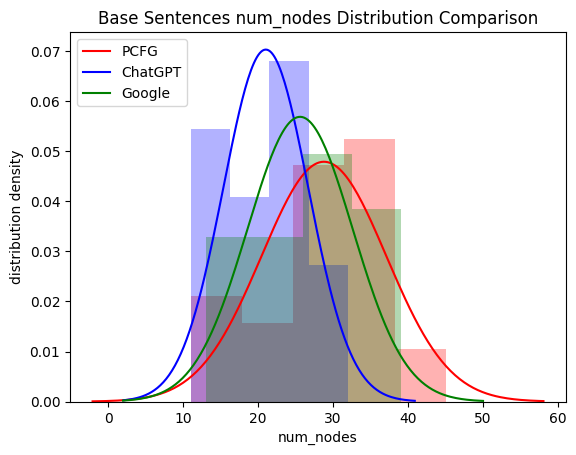

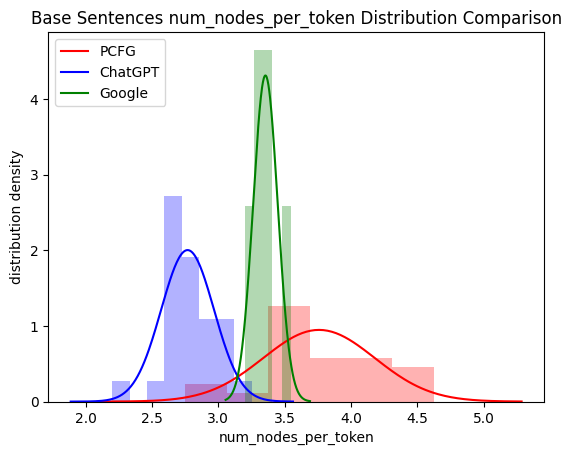

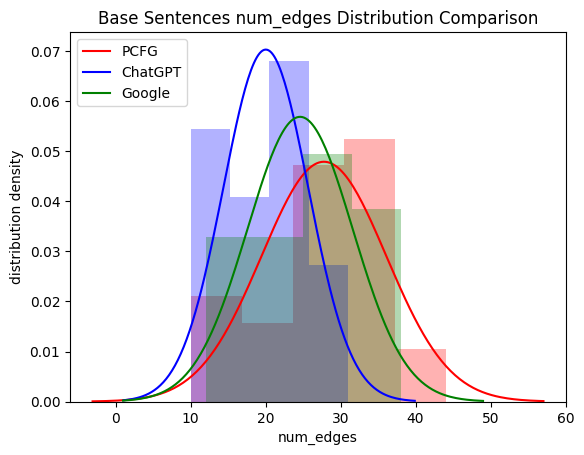

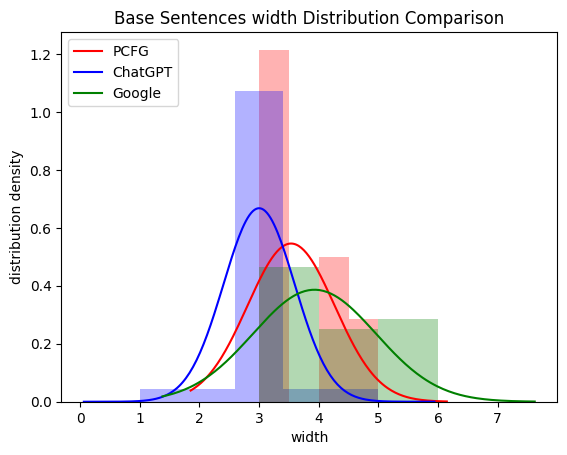

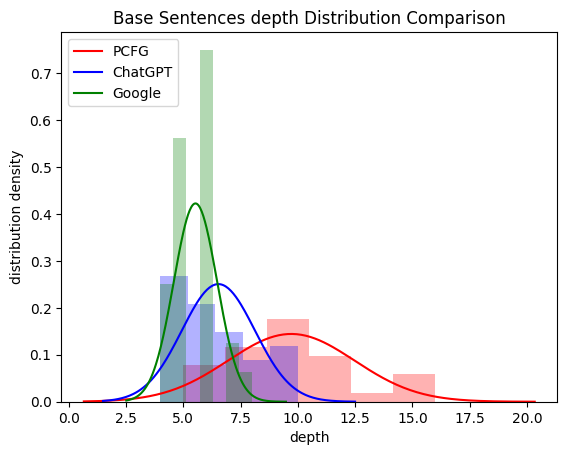

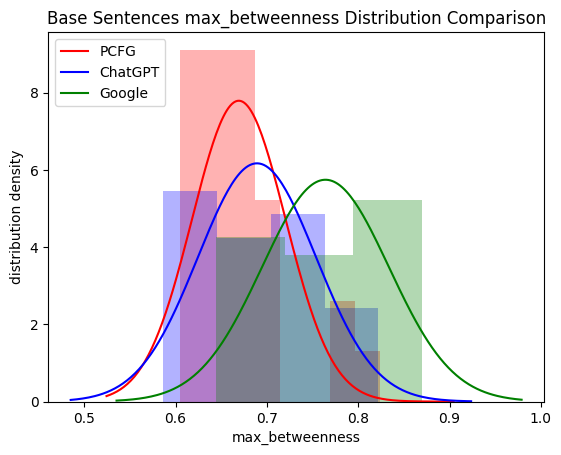

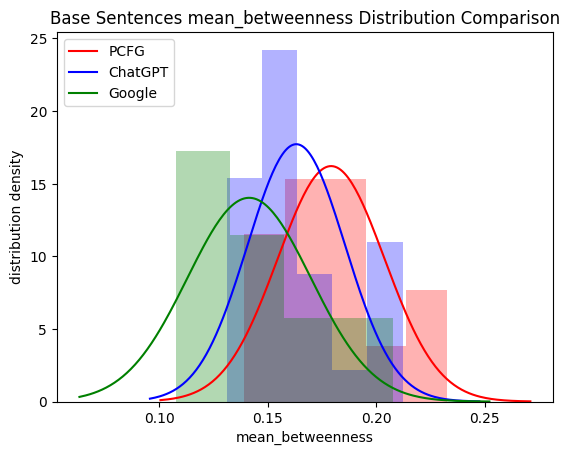

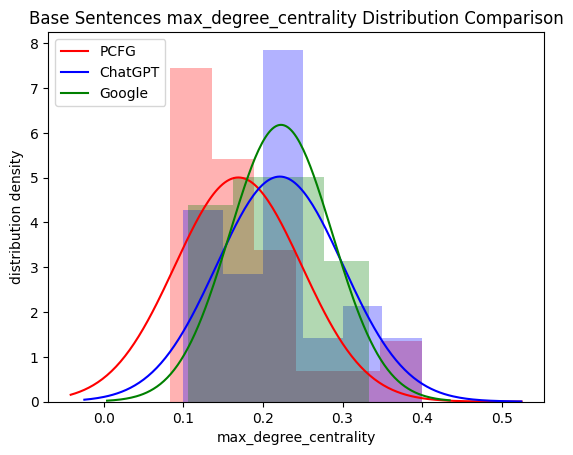

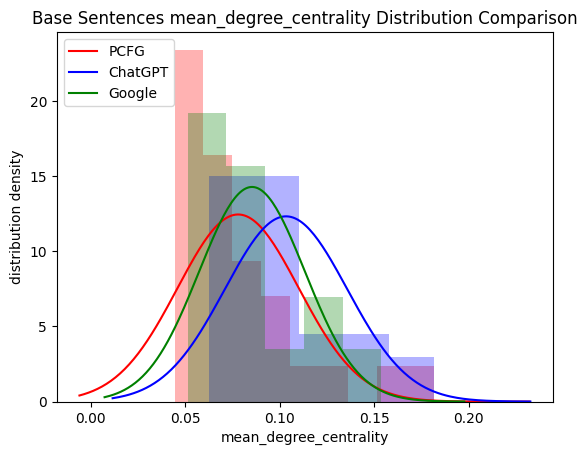

In [12]:
import seaborn as sns
from scipy import stats

for attr in attr_list:
    attr_info = metric_stat_base[attr]
    plt.figure()
    sns.distplot(attr_info['PCFG'], 
                 hist_kws={"alpha": 0.3, "color": "r"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'r', 'label':'PCFG','linestyle':'-'})
    sns.distplot(attr_info['ChatGPT'], 
                 hist_kws={"alpha": 0.3, "color": "b"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'b', 'label':'ChatGPT','linestyle':'-'})
    sns.distplot(attr_info['Google'], 
                 hist_kws={"alpha": 0.3, "color": "g"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'g', 'label':'Google','linestyle':'-'})
    plt.xlabel(attr)
    plt.ylabel('distribution density')
    plt.legend(loc = 'upper left')
    plt.title('Base Sentences {} Distribution Comparison'.format(attr))
    plt.savefig(save_dir+"\\Quantitative Analysis\\All\\{}_Base".format(attr))
    plt.show()

## Adversarial

In [13]:
MODELS = ['PCFG', 'ChatGPT', 'Google']

all_adversarial_trees = {'PCFG':[], 'ChatGPT':[], 'Google':[]}

for i in range(3):
    model = MODELS[i]
    with open(save_dir+'\\Trees\\'+model+'_Adversarial_Trees.pkl', 'rb') as f:
        trees = pickle.load(f)
        
    for tree in trees:
        all_adversarial_trees[model].append(tree)

In [14]:
adversarial_sent = read_file_lines(save_dir + '\\Sentences\\adversarial-set.sen')

In [15]:
all_adversarial_metrics = {'Sent':[], 'PCFG':[], 'ChatGPT':[], 'Google':[]}

for sent in adversarial_sent:
    all_adversarial_metrics['Sent'].append(sent)

for idx in range(len(adversarial_sent)):
    for model in MODELS:
        tree = all_adversarial_trees[model][idx]
        graph = convert_graph(tree)
        all_adversarial_metrics[model].append(network_measures(graph, model))

In [16]:
for idx in range(len(adversarial_sent)):
    print(idx)
    print(all_adversarial_metrics['Sent'][idx])
    for metric in list(all_adversarial_metrics['PCFG'][0].keys()):
        print("  {}: ".format(metric))
        print("    PCFG: {}  ChatGPT: {}  Google: {}".format(all_adversarial_metrics['PCFG'][idx][metric], 
                                                          all_adversarial_metrics['ChatGPT'][idx][metric], 
                                                          all_adversarial_metrics['Google'][idx][metric]))

0
being is weary !
  num_nodes: 
    PCFG: 14  ChatGPT: 11  Google: 13
  num_edges: 
    PCFG: 13  ChatGPT: 10  Google: 12
  width: 
    PCFG: 3  ChatGPT: 1  Google: 3
  depth: 
    PCFG: 5  ChatGPT: 5  Google: 4
  max_betweenness: 
    PCFG: (2, 0.6923076923076923)  ChatGPT: (5, 0.8)  Google: (1, 0.8181818181818182)
  mean_betweenness: 
    PCFG: 0.2234432234432234  ChatGPT: 0.19191919191919193  Google: 0.20745920745920748
  max_degree_centrality: 
    PCFG: (2, 0.23076923076923078)  ChatGPT: (5, 0.4)  Google: (1, 0.3333333333333333)
  mean_degree_centrality: 
    PCFG: 0.14285714285714282  ChatGPT: 0.18181818181818185  Google: 0.15384615384615383
1
neither no king knows nor no chalice does !
  num_nodes: 
    PCFG: 31  ChatGPT: 20  Google: 31
  num_edges: 
    PCFG: 30  ChatGPT: 19  Google: 30
  width: 
    PCFG: 5  ChatGPT: 1  Google: 4
  depth: 
    PCFG: 7  ChatGPT: 4  Google: 6
  max_betweenness: 
    PCFG: (2, 0.6620689655172414)  ChatGPT: (2, 0.9473684210526315)  Google: (1, 0.

### Distribution & Statistics of Metrics

In [17]:
metric_stat_adversarial = {}
attr_list = ['num_nodes', 'num_nodes_per_token', 'num_edges', 'width', 'depth', 
             'max_betweenness', 'mean_betweenness', 'max_degree_centrality', 'mean_degree_centrality']

for attr in attr_list:
    metric_stat_adversarial[attr] = {}
    for model in MODELS:
        if attr == 'num_nodes_per_token':
            metric_stat_adversarial[attr][model] = np.array([all_adversarial_metrics[model][i]['num_nodes']/len(adversarial_sent[i].strip().split())\
                                                      for i in range(len(adversarial_sent))])
        elif attr in ['max_betweenness', 'max_degree_centrality']:
            metric_stat_adversarial[attr][model] = np.array([all_adversarial_metrics[model][i][attr][1] for i in range(len(adversarial_sent))])
        else:
            metric_stat_adversarial[attr][model] = np.array([all_adversarial_metrics[model][i][attr] for i in range(len(adversarial_sent))])

C:\Users\duany\AppData\Local\Temp\ipykernel_17604\2474923332.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info['PCFG'],
C:\Users\duany\AppData\Local\Temp\ipykernel_17604\2474923332.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info['ChatGPT'],
C:\Users\duany\AppData\Local

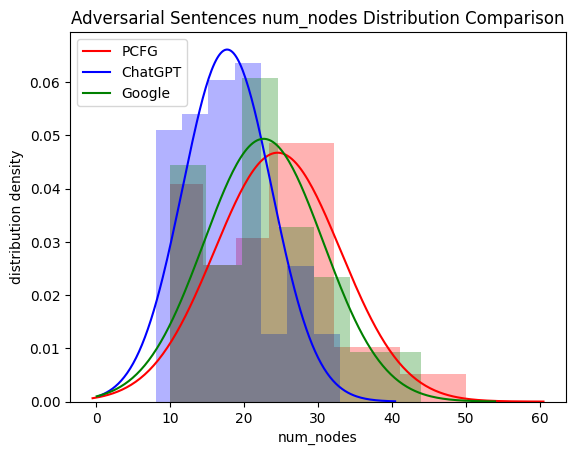

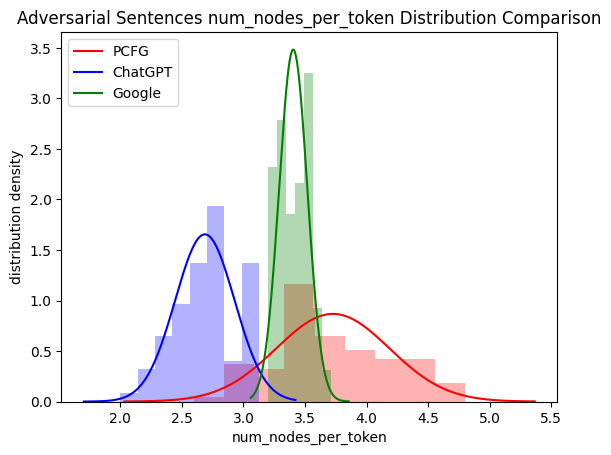

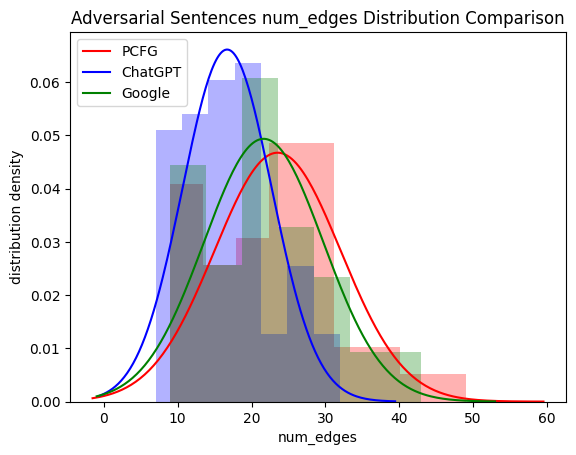

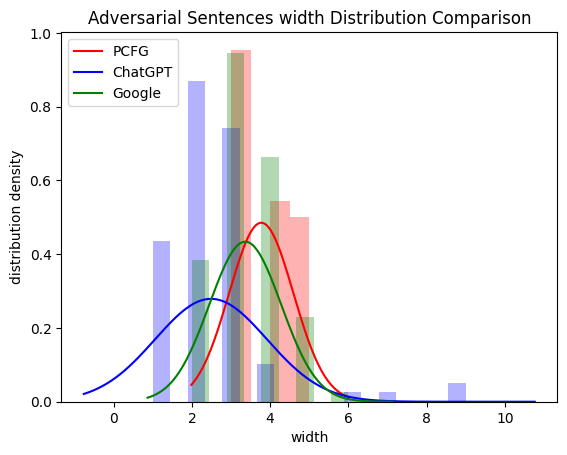

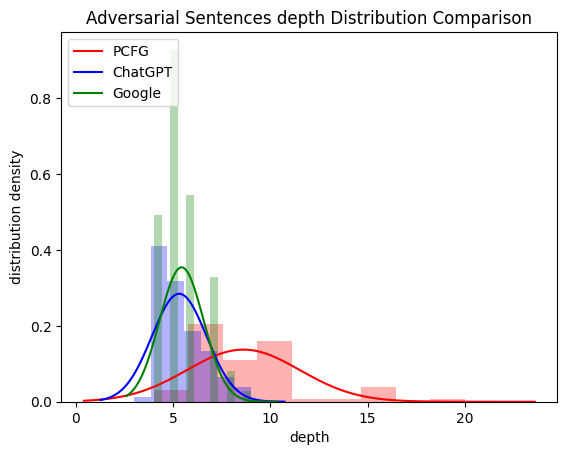

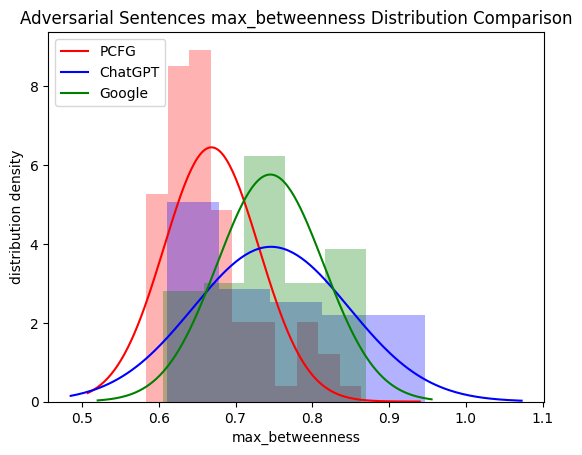

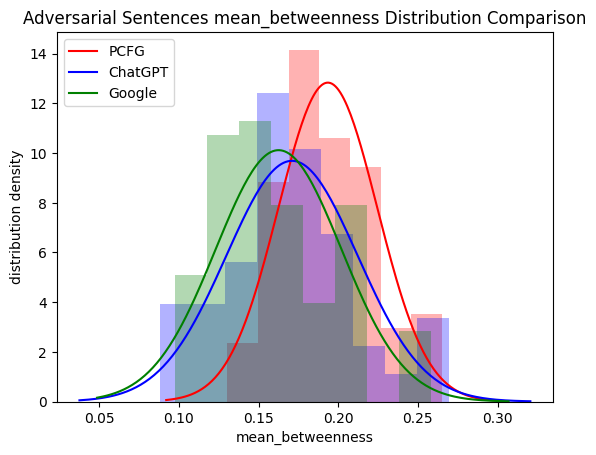

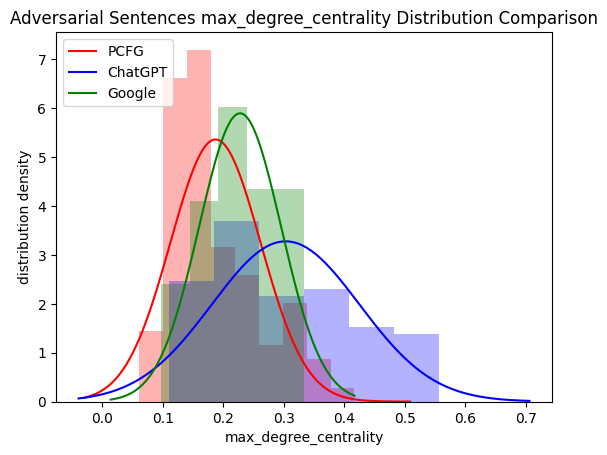

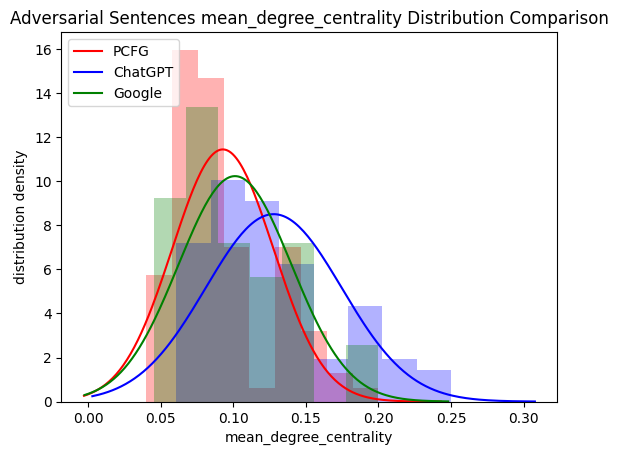

In [18]:
import seaborn as sns
from scipy import stats

for attr in attr_list:
    attr_info = metric_stat_adversarial[attr]
    plt.figure()
    sns.distplot(attr_info['PCFG'], 
                 hist_kws={"alpha": 0.3, "color": "r"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'r', 'label':'PCFG','linestyle':'-'})
    sns.distplot(attr_info['ChatGPT'], 
                 hist_kws={"alpha": 0.3, "color": "b"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'b', 'label':'ChatGPT','linestyle':'-'})
    sns.distplot(attr_info['Google'], 
                 hist_kws={"alpha": 0.3, "color": "g"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'g', 'label':'Google','linestyle':'-'})
    plt.xlabel(attr)
    plt.ylabel('distribution density')
    plt.legend(loc = 'upper left')
    plt.title('Adversarial Sentences {} Distribution Comparison'.format(attr))
    plt.savefig(save_dir+"\\Quantitative Analysis\\All\\{}_Adversarial".format(attr))
    plt.show()

## Combined Plots

C:\Users\duany\AppData\Local\Temp\ipykernel_17604\768917596.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info_base['PCFG'],
C:\Users\duany\AppData\Local\Temp\ipykernel_17604\768917596.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_info_base['ChatGPT'],
C:\Users\duany\AppDa

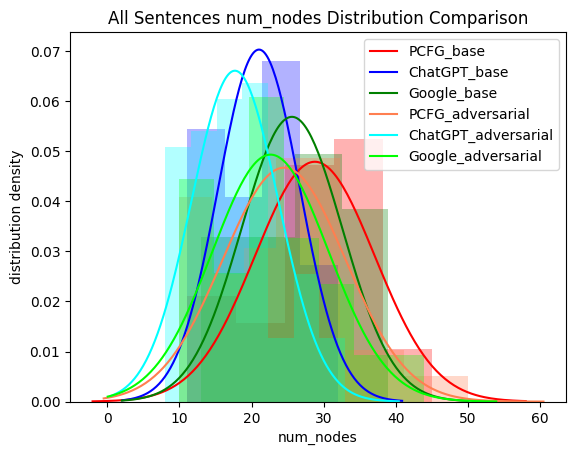

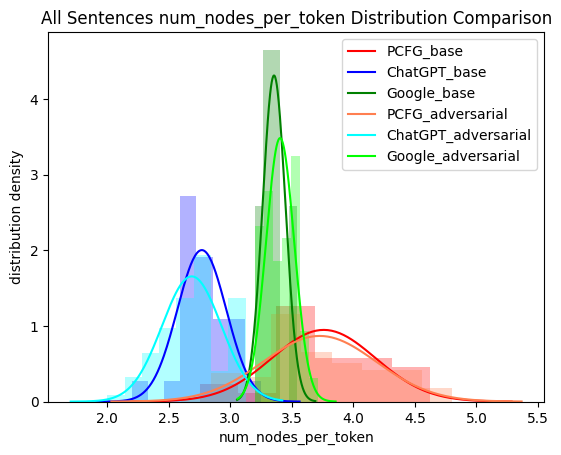

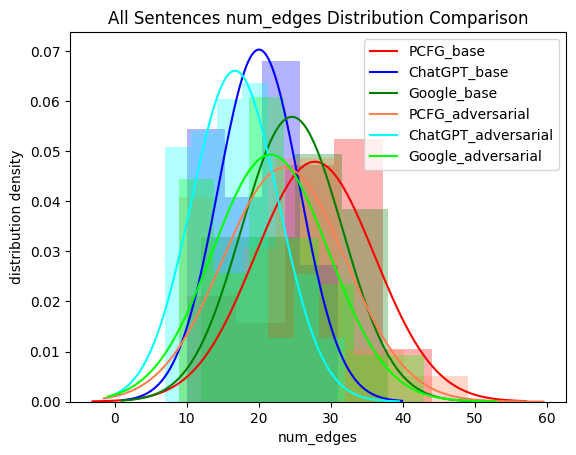

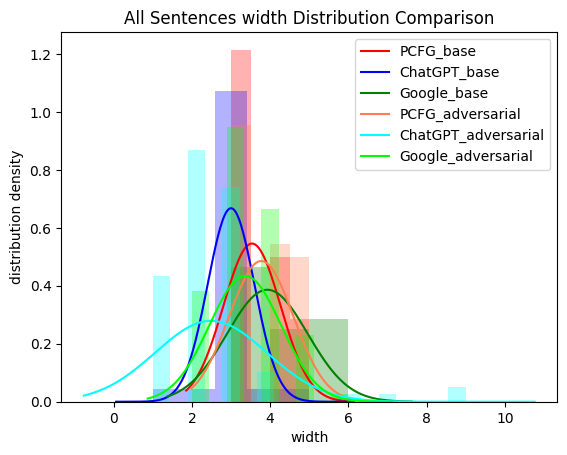

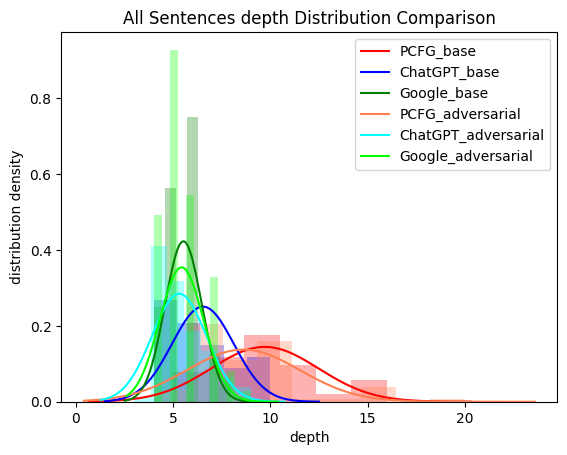

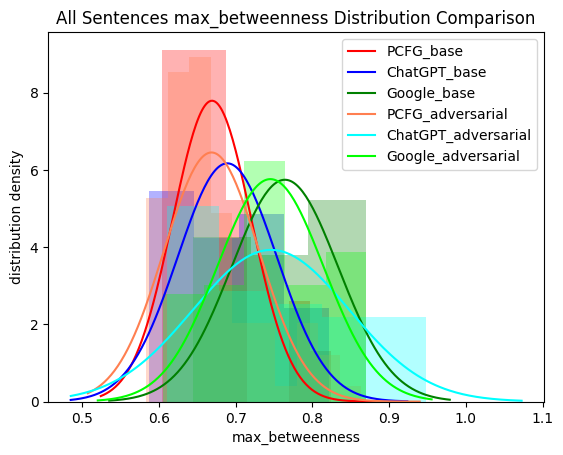

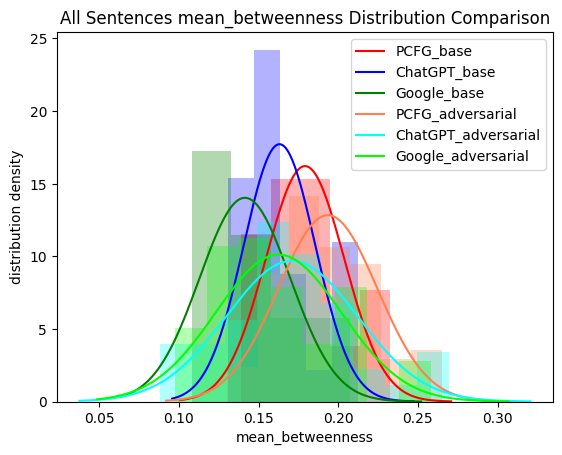

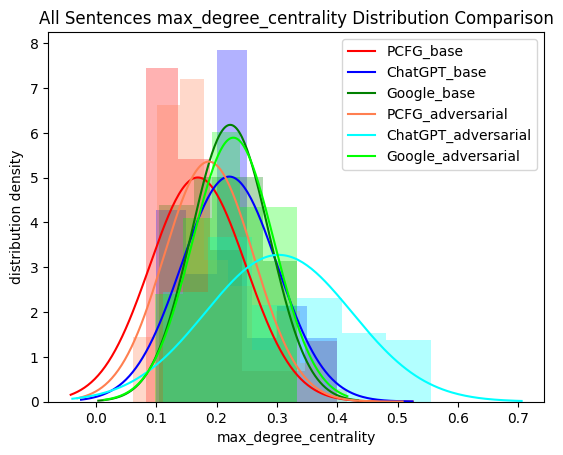

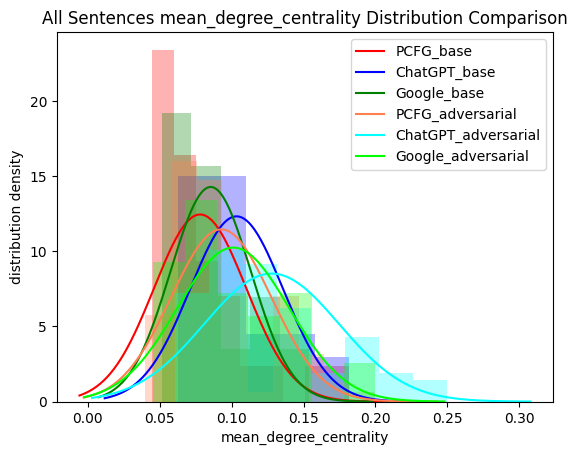

In [19]:
import seaborn as sns
from scipy import stats

for attr in attr_list:
    attr_info_base = metric_stat_base[attr]
    attr_info_adversarial = metric_stat_adversarial[attr]
    plt.figure()
    sns.distplot(attr_info_base['PCFG'], 
                 hist_kws={"alpha": 0.3, "color": "r"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'r', 'label':'PCFG_base','linestyle':'-'})
    sns.distplot(attr_info_base['ChatGPT'], 
                 hist_kws={"alpha": 0.3, "color": "b"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'b', 'label':'ChatGPT_base','linestyle':'-'})
    sns.distplot(attr_info_base['Google'], 
                 hist_kws={"alpha": 0.3, "color": "g"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'g', 'label':'Google_base','linestyle':'-'})
    
    sns.distplot(attr_info_adversarial['PCFG'], 
                 hist_kws={"alpha": 0.3, "color": "coral"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'coral', 'label':'PCFG_adversarial','linestyle':'-'})
    sns.distplot(attr_info_adversarial['ChatGPT'], 
                 hist_kws={"alpha": 0.3, "color": "cyan"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'cyan', 'label':'ChatGPT_adversarial','linestyle':'-'})
    sns.distplot(attr_info_adversarial['Google'], 
                 hist_kws={"alpha": 0.3, "color": "lime"},
                 hist=True, kde=False, fit=stats.norm, fit_kws={'color':'lime', 'label':'Google_adversarial','linestyle':'-'})
    
    plt.xlabel(attr)
    plt.ylabel('distribution density')
    plt.legend(loc = 'upper right')
    plt.title('All Sentences {} Distribution Comparison'.format(attr))
    plt.savefig(save_dir+"\\Quantitative Analysis\\All\\{}_Combined".format(attr))
    plt.show()